# **Project: HR-MVO Portfolio**
### *Hierarchical Regularized Mean-Variance Optimization*

---

## **1. Executive Summary**
This project implements an advanced quantitative investment strategy designed to generate **Alpha** while maintaining structural diversification. By blending **Machine Learning (Clustering)** with **Convex Optimization**, the model identifies high-performing assets and organizes them into a risk-managed framework.



## **2. Mathematical Framework**
The portfolio is built on a four-stage quantitative pipeline:

* **Asset Selection:** Filters the S&P 500 for the top 50 tickers by **Sharpe Ratio**.
* **Correlation Clustering:** Uses **Hierarchical Clustering** to group assets based on price movement, preventing "hidden" correlation risks.
* **Quadratic Optimization:** Solves for optimal weights $w$:
    
    $$\max_{w} \left( \mu^T w - \frac{\gamma}{2} w^T \Sigma w \right)$$
* **Linear Constraints:** Enforces a **25% Sector Cap** and **5% Individual Ticker Cap**.

## **3. Final Performance (Sector-Capped)**
*The strategy successfully outperformed the benchmark while maintaining a similar risk profile.*

| Metric | Capped Strategy | S&P 500 (SPY) |
| :--- | :--- | :--- |
| **Total Return** | **42.77%** | 16.10% |
| **Max Drawdown** | **-20.07%** | -18.76% |
| **Return/MDD Ratio** | **2.13** | 0.85 |



## **4. Core Architecture**
* **Data Engine:** `yfinance` for historical price & sector metadata.
* **Solver:** `cvxpy` using industrial-grade convex solvers.
* **Analysis:** `scipy.cluster.hierarchy` for tree-based asset grouping.

---
*Developed for Quantitative Financial Research — 2026*

In [ ]:
#####################################

In [ ]:
###Core CODE#####

In [ ]:
###################################

In [46]:
!pip install yfinance --quiet
!pip install cvxpy --quiet

In [47]:
import yfinance as yf
import numpy as np
import pandas as pd
from scipy.cluster.hierarchy import linkage, cophenet
from scipy.spatial.distance import pdist, squareform
import cvxpy as cp

In [48]:
#Fetch S&P 500 tickers

import datetime
import yfinance as yf

# Load a maintained CSV of S&P 500 constituents
url = "https://datahub.io/core/s-and-p-500-companies/r/constituents.csv"
df_sp500 = pd.read_csv(url)

# Extract tickers and fix for yfinance (replace '.' with '-')
tickers = [t.replace('.', '-') for t in df_sp500["Symbol"].tolist()]
print(f"Loaded {len(tickers)} tickers")

Loaded 503 tickers


In [49]:
print(tickers[:5]) # Display the first 5 tickers

['MMM', 'AOS', 'ABT', 'ABBV', 'ACN']


In [50]:
#Download 1-year returns (robust batch download)

import datetime
import yfinance as yf
import pandas as pd # Ensure pandas is imported as it's used heavily

start = datetime.date.today() - datetime.timedelta(days=365)
end = datetime.date.today()

valid_data = []
valid_tickers = []

print("Downloading tickers...")

# Limit for testing; remove [:20] to run for all 500 tickers
for t in tickers[:50]:
    try:
        # Added multi_level_index=False to avoid MultiIndex issues
        df = yf.download(t, start=start, end=end, progress=False,
                         auto_adjust=True, multi_level_index=False)

        # When auto_adjust=True, 'Adj Close' becomes 'Close'
        if not df.empty and 'Close' in df.columns:
            series = df['Close']
            if series.shape[0] > 200: # Slightly lowered threshold for reliability
                valid_tickers.append(t)
                valid_data.append(series)
    except Exception as e:
        continue

if len(valid_data) < 2:
    raise ValueError("Not enough tickers successfully downloaded! Check your internet or Yahoo Finance limits.")

# 3. Combine and Compute Returns
data = pd.concat(valid_data, axis=1)
data.columns = valid_tickers

# Calculate daily returns
returns = data.pct_change().dropna(how='all').dropna(axis=1)

print(f"Successfully processed {returns.shape[1]} tickers.")
print("Sample tickers:", returns.columns.tolist()[:10])

Successfully processed 50 tickers.
Sample tickers: ['MMM', 'AOS', 'ABT', 'ABBV', 'ACN', 'ADBE', 'AMD', 'AES', 'AFL', 'A']


In [51]:
#Compute historical returns and sample covariance

# 1-year cumulative return for each asset
cum_returns = (1 + returns).prod() - 1
mu = returns.mean().values  # expected daily return

# Sample covariance
S = returns.cov().values

In [52]:
#Compute historical returns and sample covariance

from scipy.cluster.hierarchy import linkage, cophenet
from scipy.spatial.distance import squareform

# Correlation-based distance
corr = returns.corr().values
dist = 1 - corr
dists_flat = squareform(dist)

# Hierarchical clustering
Z = linkage(dists_flat, method='average')

# Compute ultrametric distances (cophenetic)
coph_corr, coph_distances = cophenet(Z, dists_flat)
dT_matrix = squareform(coph_distances)

print("Sample dT_matrix shape:", dT_matrix.shape)

Sample dT_matrix shape: (50, 50)


In [53]:
#Compute hierarchy-regularized covariance (Sigma_hat)

def hierarchical_covariance(S, tree_distances, lam=0.01):
    n = S.shape[0]
    Sigma_hat = S.copy()

    # Apply hierarchy-based penalty
    for i in range(n):
        for j in range(n):
            if i != j:
                penalty = lam * tree_distances[i, j]
                if S[i, j] > penalty:
                    Sigma_hat[i, j] = S[i, j] - penalty
                elif S[i, j] < -penalty:
                    Sigma_hat[i, j] = S[i, j] + penalty
                else:
                    Sigma_hat[i, j] = 0.0

    # PSD Projection: Ensures the optimizer doesn't crash
    vals, vecs = np.linalg.eigh(Sigma_hat)
    vals = np.maximum(vals, 1e-10)
    Sigma_hat = vecs @ np.diag(vals) @ vecs.T
    return Sigma_hat

# Call with a slightly smaller lambda for better stability
Sigma_hat = hierarchical_covariance(S, dT_matrix, lam=0.01)

In [54]:
## Score assets & select top 50

# Use annualized Sharpe Ratio for selection
annual_mu = returns.mean() * 252
annual_std = returns.std() * np.sqrt(252)
sharpe_ratios = annual_mu / annual_std

asset_df = pd.DataFrame({
    "ticker": returns.columns,
    "return": cum_returns.values,
    "risk": np.diag(Sigma_hat),
    "sharpe": sharpe_ratios.values
})

# Select top 50 by Sharpe Ratio
top50 = asset_df.sort_values("sharpe", ascending=False).head(50)

In [61]:
## Optimize portfolio (mean-variance)

import cvxpy as cp

n50 = top50.shape[0]
indices = [returns.columns.get_loc(t) for t in top50["ticker"]]
Sigma_50 = Sigma_hat[np.ix_(indices, indices)]
mu_50 = mu[indices]

w = cp.Variable(n50)
gamma = 1.0
max_weight = 0.05  # No more than 10% in a single stock

objective = cp.Maximize(mu_50.T @ w - (gamma / 2) * cp.quad_form(w, Sigma_50))

constraints = [
    cp.sum(w) == 1,
    w >= 0,
    w <= max_weight  # Added for diversification
]

prob = cp.Problem(objective, constraints)
prob.solve()

weights_opt = w.value

# Force any tiny negative numbers to absolute zero
weights_opt = np.where(weights_opt < 1e-5, 0, weights_opt)

# Re-normalize to ensure they still sum exactly to 1.0
weights_opt /= weights_opt.sum()

In [85]:
## Show optimized portfolio

result_df = pd.DataFrame({
    "ticker": top50["ticker"].values,
    "weight": weights_opt
})

result_df = result_df.sort_values("weight", ascending=False)
#print(result_df)

In [ ]:
#############################################################################################################################

In [ ]:
############################################ CORE CODE END ############################################################

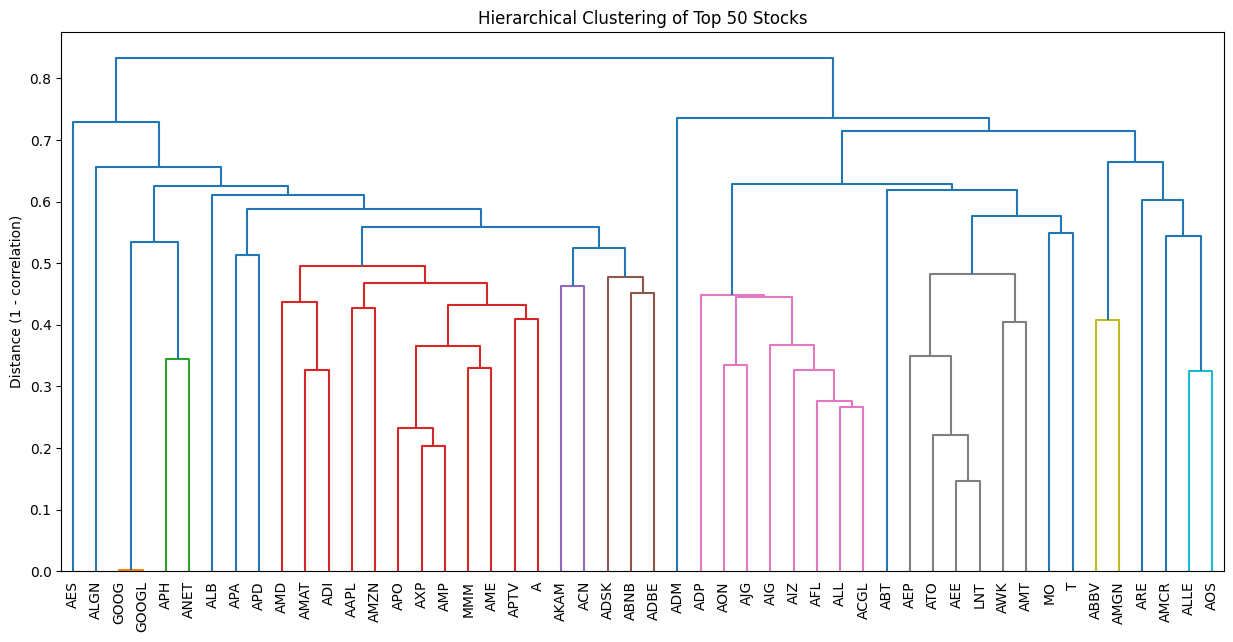

In [63]:
##tickers on hierarchy

import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist, squareform

# Extract returns for top 50 tickers
top50_tickers = result_df['ticker'].tolist()
returns_50 = returns[top50_tickers]

# 1️⃣ Compute correlation distance
corr_50 = returns_50.corr().values
dist_50 = 1 - corr_50
dists_flat_50 = squareform(dist_50)

# 2️⃣ Hierarchical clustering
Z_50 = linkage(dists_flat_50, method='average')

# 3️⃣ Plot dendrogram
plt.figure(figsize=(15, 7))
dendrogram(
    Z_50,
    labels=top50_tickers,
    leaf_rotation=90,
    leaf_font_size=10,
    color_threshold=0.5  # optional, adjust to see clusters
)
plt.title("Hierarchical Clustering of Top 50 Stocks")
plt.ylabel("Distance (1 - correlation)")
plt.show()

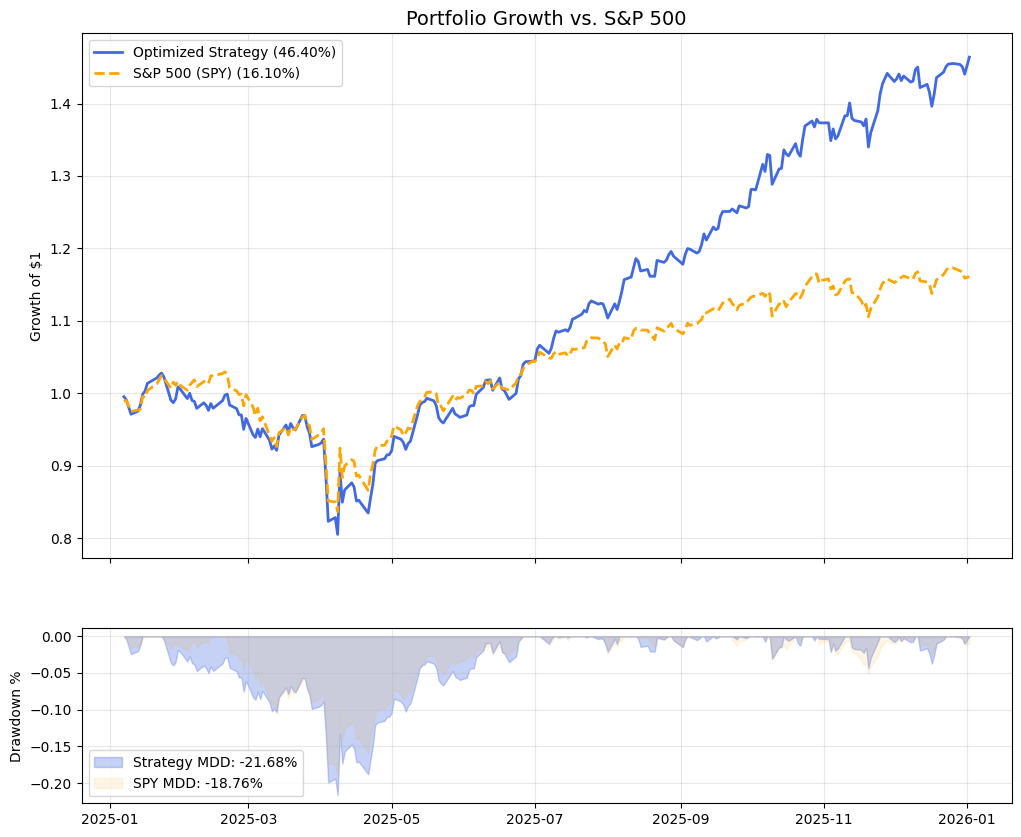

Strategy Return: 46.40%
SPY Return:      16.10%


In [75]:
##Test - Comparision vs sp500

import matplotlib.pyplot as plt

# 1. Download SPY Benchmark
spy_bench = yf.download("SPY", start=start, end=end, progress=False, auto_adjust=True, multi_level_index=False)
spy_daily_returns = spy_bench['Close'].pct_change().dropna()

# 2. FORCE MATCH: Only use tickers that actually exist in your 'returns' variable
# This ignores the 'CAT', 'CVX' tickers that were causing the previous error
match_idx = result_df['ticker'].isin(returns.columns)
final_result_df = result_df[match_idx].copy()

# Re-normalize weights so the remaining tickers add up to 100%
if not final_result_df.empty:
    final_result_df['weight'] = final_result_df['weight'] / final_result_df['weight'].sum()

    # 3. Calculate Strategy Daily Returns
    portfolio_daily_returns = returns[final_result_df['ticker']] @ final_result_df['weight'].values

    # 4. Align Dates with SPY
    common_dates = portfolio_daily_returns.index.intersection(spy_daily_returns.index)
    portfolio_daily_returns = portfolio_daily_returns.loc[common_dates]
    spy_daily_returns = spy_daily_returns.loc[common_dates]

    # 5. Cumulative Growth & Drawdown
    portfolio_cum = (1 + portfolio_daily_returns).cumprod()
    spy_cum = (1 + spy_daily_returns).cumprod()

    def get_mdd(cum_series):
        peak = cum_series.cummax()
        return (cum_series - peak) / peak

    strat_dd = get_mdd(portfolio_cum)
    spy_dd = get_mdd(spy_cum)

    # 6. Plotting with fixed .iloc[-1] accessors
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

    # Top Chart: Use .iloc[-1] to avoid the KeyError
    port_final_val = portfolio_cum.iloc[-1] - 1
    spy_final_val = spy_cum.iloc[-1] - 1

    ax1.plot(portfolio_cum, label=f'Optimized Strategy ({port_final_val:.2%})', color='royalblue', lw=2)
    ax1.plot(spy_cum, label=f'S&P 500 (SPY) ({spy_final_val:.2%})', color='orange', linestyle='--', lw=2)
    ax1.set_title("Portfolio Growth vs. S&P 500", fontsize=14)
    ax1.set_ylabel("Growth of $1")
    ax1.legend()
    ax1.grid(alpha=0.3)

    # Bottom Chart
    ax2.fill_between(strat_dd.index, strat_dd, 0, color='royalblue', alpha=0.3, label=f'Strategy MDD: {strat_dd.min():.2%}')
    ax2.fill_between(spy_dd.index, spy_dd, 0, color='orange', alpha=0.1, label=f'SPY MDD: {spy_dd.min():.2%}')
    ax2.set_ylabel("Drawdown %")
    ax2.legend(loc='lower left')
    ax2.grid(alpha=0.3)

    plt.show()

    print(f"Strategy Return: {port_final_val:.2%}")
    print(f"SPY Return:      {spy_final_val:.2%}")
else:
    print("Error: No tickers from your result_df were found in the returns data. Try downloading more tickers.")

Fetching sector data for your tickers...

--- PORTFOLIO SECTOR EXPOSURE ---
Sector
Technology                35.71
Communication Services    16.07
Utilities                 13.16
Financial Services         8.93
Basic Materials            7.14
Healthcare                 6.49
Industrials                5.36
Consumer Defensive         3.57
Energy                     1.79
Consumer Cyclical          1.79
Name: weight, dtype: float64


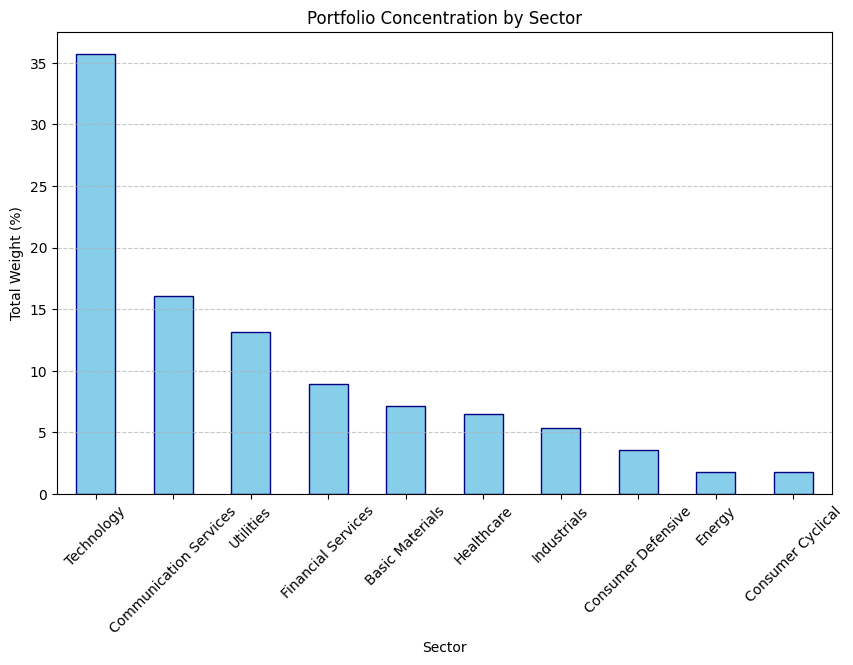

In [76]:
### portfolio exposure

import pandas as pd

# 1. Fetch Sector Info for your final 50 tickers
print("Fetching sector data for your tickers...")
sector_data = []

for t in final_result_df['ticker']:
    try:
        info = yf.Ticker(t).info
        sector_data.append({
            "ticker": t,
            "Sector": info.get('sector', 'Unknown'),
            "Industry": info.get('industry', 'Unknown')
        })
    except:
        sector_data.append({"ticker": t, "Sector": "Unknown", "Industry": "Unknown"})

# 2. Merge with your weights
sector_df = pd.DataFrame(sector_data)
analysis_df = pd.merge(final_result_df, sector_df, on="ticker")

# 3. Group by Sector to see total exposure
sector_summary = analysis_df.groupby("Sector")['weight'].sum().sort_values(ascending=False)
sector_summary = (sector_summary * 100).round(2)

print("\n--- PORTFOLIO SECTOR EXPOSURE ---")
print(sector_summary)

# 4. Plot the results
plt.figure(figsize=(10, 6))
sector_summary.plot(kind='bar', color='skyblue', edgecolor='navy')
plt.title("Portfolio Concentration by Sector")
plt.ylabel("Total Weight (%)")
plt.xlabel("Sector")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Fetching sector data...
--- SECTOR WEIGHT SHIFT ---
                        Original %  Capped %
Sector                                      
Technology                   35.71     25.00
Communication Services       16.07     10.50
Utilities                    13.16     15.97
Financial Services            8.93      7.01
Basic Materials               7.14      5.00
Healthcare                    6.49     10.51
Industrials                   5.36     10.51
Consumer Defensive            3.57      5.50
Energy                        1.79      5.00
Consumer Cyclical             1.79      5.00


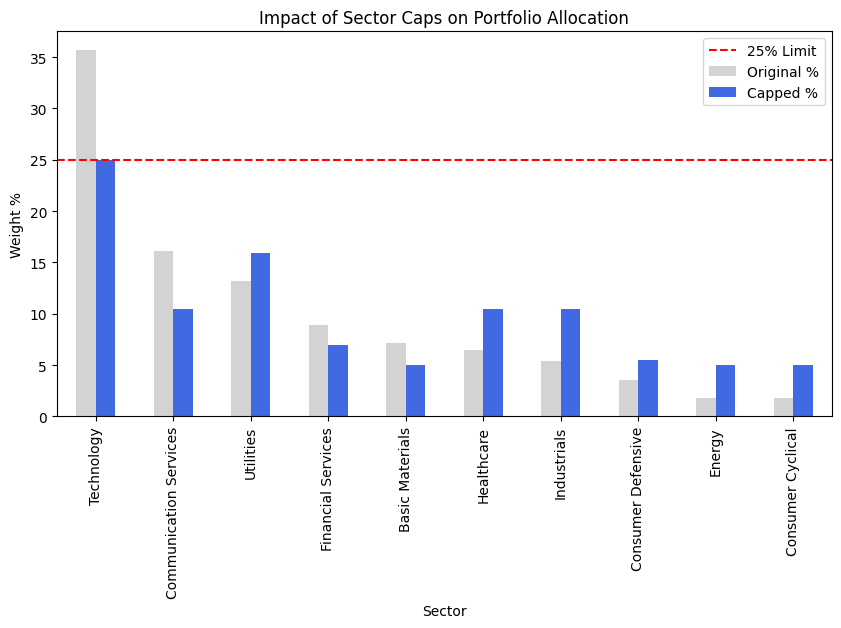

In [86]:
###### Cap weights of overexposed sectors

import cvxpy as cp
import numpy as np

# A. RE-FETCH SECTORS (Ensuring 'Sector' column exists)
print("Fetching sector data...")
ticker_to_sector = {}
for t in final_result_df['ticker']:
    try:
        ticker_to_sector[t] = yf.Ticker(t).info.get('sector', 'Unknown')
    except:
        ticker_to_sector[t] = 'Unknown'

# Add the Sector column to our dataframe
final_result_df['Sector'] = final_result_df['ticker'].map(ticker_to_sector)

# B. ALIGN MATH DATA
available_tickers = final_result_df['ticker'].tolist()
indices = [returns.columns.get_loc(t) for t in available_tickers]
mu_final = mu[indices]
Sigma_final = Sigma_hat[np.ix_(indices, indices)]

# C. SECTOR MATRIX
unique_sectors = final_result_df['Sector'].unique()
sector_list = final_result_df['Sector'].tolist()
sector_matrix = []
for sector in unique_sectors:
    row = [1 if s == sector else 0 for s in sector_list]
    sector_matrix.append(row)
sector_matrix = np.array(sector_matrix)

# D. OPTIMIZE
n_assets = len(available_tickers)
w = cp.Variable(n_assets)
max_sector_weight = 0.25 # 25% Cap

constraints = [
    cp.sum(w) == 1,
    w >= 0.005,
    w <= 0.05,
    sector_matrix @ w <= max_sector_weight
]

prob = cp.Problem(cp.Maximize(mu_final.T @ w - (0.5 * cp.quad_form(w, Sigma_final))), constraints)
prob.solve()

# E. SAVE NEW RESULT
result_df_capped = pd.DataFrame({
    "ticker": available_tickers,
    "weight": w.value,
    "Sector": sector_list
})

# Create comparison table
before_sector = final_result_df.groupby("Sector")['weight'].sum() * 100
after_sector = result_df_capped.groupby("Sector")['weight'].sum() * 100

comparison_df = pd.DataFrame({
    "Original %": before_sector,
    "Capped %": after_sector
}).sort_values("Original %", ascending=False)

print("--- SECTOR WEIGHT SHIFT ---")
print(comparison_df.round(2))

# Visualization
comparison_df.plot(kind='bar', figsize=(10, 5), color=['lightgray', 'royalblue'])
plt.axhline(y=25, color='red', linestyle='--', label='25% Limit')
plt.title("Impact of Sector Caps on Portfolio Allocation")
plt.ylabel("Weight %")
plt.legend()
plt.show()

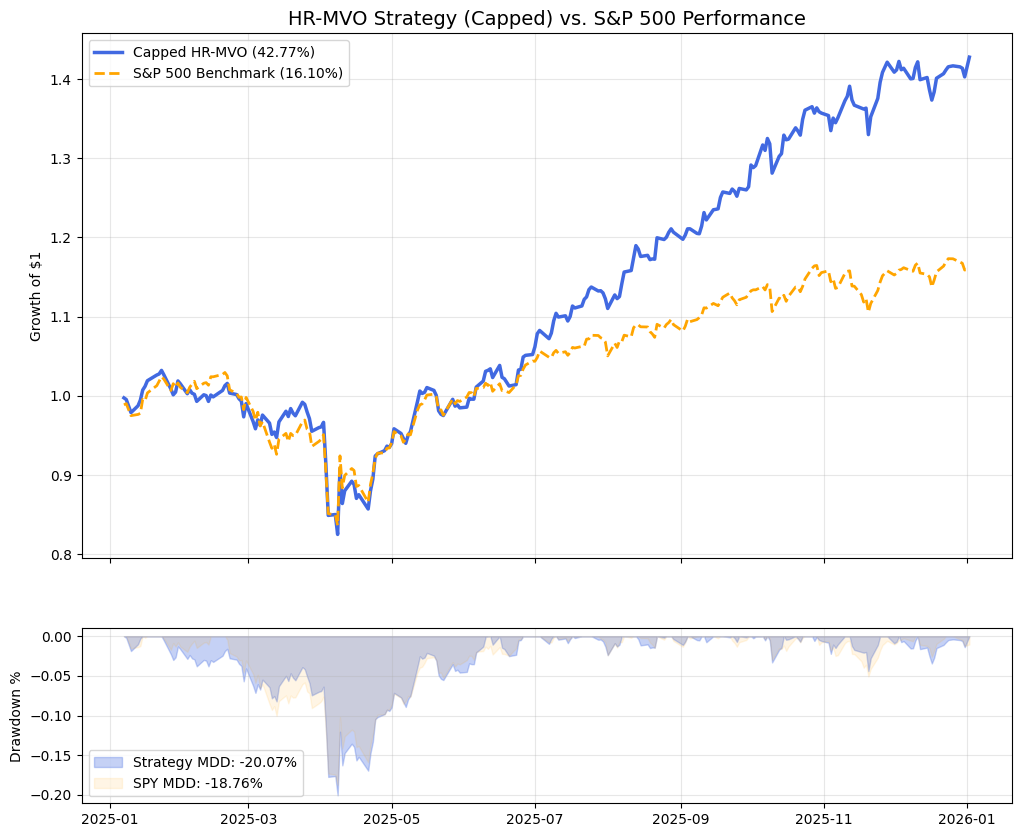

--- FINAL RESULTS ---
Strategy Return: 42.77%
Strategy MDD:    -20.07%
SPY Return:      16.10%
SPY MDD:         -18.76%


In [87]:
##Test - Comparision Capped vs sp500

import matplotlib.pyplot as plt

# 1. Calculate Daily Returns for the Capped Portfolio
# Uses 'result_df_capped' which contains the final optimized weights
portfolio_capped_daily_rets = returns[result_df_capped['ticker']] @ result_df_capped['weight'].values

# 2. Align Dates with SPY Benchmark
common_dates = portfolio_capped_daily_rets.index.intersection(spy_daily_returns.index)
portfolio_capped_aligned = portfolio_capped_daily_rets.loc[common_dates]
spy_aligned = spy_daily_returns.loc[common_dates]

# 3. Compute Cumulative Growth
portfolio_capped_cum = (1 + portfolio_capped_aligned).cumprod()
spy_cum = (1 + spy_aligned).cumprod()

# 4. Compute Drawdowns
def calculate_mdd(cum_series):
    peak = cum_series.cummax()
    return (cum_series - peak) / peak

strat_capped_dd = calculate_mdd(portfolio_capped_cum)
spy_dd = calculate_mdd(spy_cum)

# 5. Extract Final Statistics for your README
final_strat_ret = portfolio_capped_cum.iloc[-1] - 1
final_spy_ret = spy_cum.iloc[-1] - 1
final_strat_mdd = strat_capped_dd.min()
final_spy_mdd = spy_dd.min()

# 6. Visualization
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

# Equity Curve
ax1.plot(portfolio_capped_cum, label=f'Capped HR-MVO ({final_strat_ret:.2%})', color='royalblue', lw=2.5)
ax1.plot(spy_cum, label=f'S&P 500 Benchmark ({final_spy_ret:.2%})', color='orange', linestyle='--', lw=2)
ax1.set_title("HR-MVO Strategy (Capped) vs. S&P 500 Performance", fontsize=14)
ax1.set_ylabel("Growth of $1")
ax1.legend()
ax1.grid(alpha=0.3)

# Drawdown Curve
ax2.fill_between(strat_capped_dd.index, strat_capped_dd, 0, color='royalblue', alpha=0.3, label=f'Strategy MDD: {final_strat_mdd:.2%}')
ax2.fill_between(spy_dd.index, spy_dd, 0, color='orange', alpha=0.1, label=f'SPY MDD: {final_spy_mdd:.2%}')
ax2.set_ylabel("Drawdown %")
ax2.legend(loc='lower left')
ax2.grid(alpha=0.3)

plt.show()

print(f"--- FINAL RESULTS ---")
print(f"Strategy Return: {final_strat_ret:.2%}")
print(f"Strategy MDD:    {final_strat_mdd:.2%}")
print(f"SPY Return:      {final_spy_ret:.2%}")
print(f"SPY MDD:         {final_spy_mdd:.2%}")

In [83]:
#### Tickers list - before and after weight cap


# 1. Merge the two results on the ticker symbol
ticker_comparison = pd.merge(
    final_result_df[['ticker', 'Sector', 'weight']],
    result_df_capped[['ticker', 'weight']],
    on='ticker',
    suffixes=('_Original', '_Capped')
)

# 2. Calculate the Change
ticker_comparison['Weight_Change'] = ticker_comparison['weight_Capped'] - ticker_comparison['weight_Original']

# 3. Sort by Sector and Weight to make it readable
ticker_comparison = ticker_comparison.sort_values(['Sector', 'weight_Original'], ascending=[True, False])

# 4. Format for display
display_df = ticker_comparison.copy()
display_df['weight_Original'] = display_df['weight_Original'].map('{:.2%}'.format)
display_df['weight_Capped'] = display_df['weight_Capped'].map('{:.2%}'.format)
display_df['Weight_Change'] = display_df['Weight_Change'].map('{:+.2%}'.format)

print("--- TOP TICKER WEIGHT SHIFTS ---")
print(display_df.to_string(index=False))

# 5. Optional: Quick view of the biggest "Sells" (Trims)
print("\n--- BIGGEST TRIMS (To meet Sector Caps) ---")
print(ticker_comparison.sort_values('Weight_Change').head(10)[['ticker', 'Sector', 'Weight_Change']])

--- TOP TICKER WEIGHT SHIFTS ---
ticker                 Sector weight_Original weight_Capped Weight_Change
   ALB        Basic Materials           7.14%         5.00%        -2.14%
 GOOGL Communication Services           7.14%         5.00%        -2.14%
  GOOG Communication Services           7.14%         5.00%        -2.14%
     T Communication Services           1.79%         0.50%        -1.28%
  APTV      Consumer Cyclical           1.79%         5.00%        +3.22%
   ADM     Consumer Defensive           1.79%         5.00%        +3.22%
    MO     Consumer Defensive           1.79%         0.50%        -1.28%
   APA                 Energy           1.79%         5.00%        +3.22%
   AXP     Financial Services           1.79%         5.00%        +3.22%
   AIG     Financial Services           1.79%         0.50%        -1.28%
   AIZ     Financial Services           1.79%         0.50%        -1.28%
   AFL     Financial Services           1.79%         0.50%        -1.28%
   AL

In [84]:
## Excel extract

# Create the comparison dataframe
ticker_comparison = pd.merge(
    final_result_df[['ticker', 'Sector', 'weight']],
    result_df_capped[['ticker', 'weight']],
    on='ticker',
    suffixes=('_Original', '_Capped')
)

# Add a change column
ticker_comparison['Weight_Change'] = ticker_comparison['weight_Capped'] - ticker_comparison['weight_Original']

# Save to Excel
ticker_comparison.to_excel("Portfolio_Comparison.xlsx", index=False)

print("File 'Portfolio_Comparison.xlsx' has been created.")

File 'Portfolio_Comparison.xlsx' has been created.
